# Part 1: Questions to text and lectures.

A) Please answer my questions to the Segal and Heer paper we read during lecture 7 and 8.

* What is the Oxford English Dictionary's defintion of a narrative?

*an account of a series of events, facts, etc., given in order and with the establishing of connections between them.*

* What is your favorite visualization among the examples in section 3? Explain why in a few words.

My favorite case is the Gapminder Human Development Trends focusing on global income and health trends. The main reason is that the checklist structure is used in this case to allow the dense information to be clearly comprehended by the reader. Additionally, in section 3, the exposed interactivity is implemented as a part of the narrative, not merely an afterthought.

* What's the point of Figure 7?

Figure 7 is a design space analysis table which relates each example to specific design strategies observed across the dataset.It contains three part of features: genre, visual narrative tactics, and narrative structure tactics.

* Use Figure 7 to find the most common design choice within each category for the Visual narrative and Narrative structure (the categories within visual narrative are 'visual structuring', 'highlighting', etc).

For the Visual narrative, "Consistent Visual Platform", "Feature Distinction" and "Animated Transitions" are the most popular categories within visual structuring, visual structuring and Transition Guidance respectively. In terms of Narrative Structure, "User Directed Path" and "Linear" are most popular within ordering; "Hover Highlighting / Details", "Filtering / Selection / Search" and "Very Limited Interactivity" are most common within interactivity; "Captions / Headlines" and "annotations" are the most popular category within messaging. 

* Check out Figure 8 and section 4.3. What is your favorite genre of narrative visualization? Why? What is your least favorite genre? Why?

My favorite genre is the annotated chart, since I can draw the points from the dense information in a short time and the annotation could provide me with some important details. Magazine style is the least favorite genre, because it has too much words to read where I can not get the point qucikly and precisely.

B) Also please answer the questions to my talk on explanatory data visualization

* What are the three key elements to keep in mind when you design an explanatory visualization?


 1) start with a question  
 
 2) allow exploration 
 
 3) know your readers

* In the video I talk about (1) overview first, (2) zoom and filter, (3) details on demand.

$\qquad \bullet$ Go online and find a visualization that follows these principles (don't use one from the video).

 $\qquad \bullet$  Explain how it does achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.

This data visualization example gives an overview of data compiled from over 1000 major Hollywood films of the last eight years. You could choose filter: Worldwide gross, size and year. In terms of details, when put the arrow to the point, it will show the detail of the film as shown the figure below.

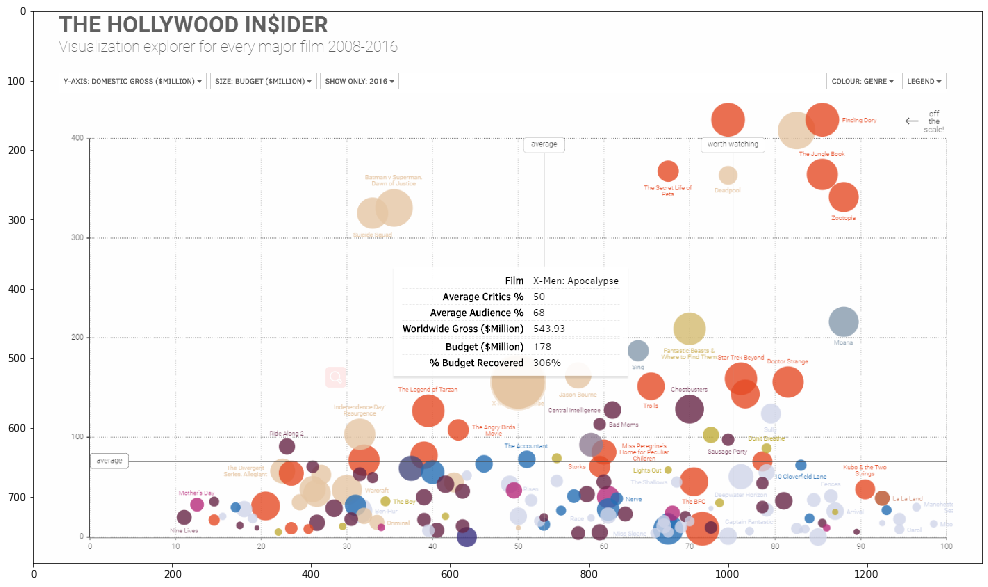

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
I1 = mpimg.imread('dataExample1.png')
plt.figure(figsize=(17,17))
plt.imshow(I1)
plt.show() 

* Explain in your own words: How is explanatory data analysis different from exploratory data analysis?

Exploratory data analysis refers to discover patterns and test hypothesis using summary statistics and graphical representations. Explanatory data analysis refers to tell story in terms of the data to readers.

# Part 2: Random forest and weather

In [1]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
from dateutil.parser import parse
import warnings
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

## Part 2A: Random forest binary classification.

In [2]:
df = pd.read_csv('Police_report_dateform.csv',parse_dates = [['Date','Time']])
df_save = df.copy()

In [3]:
df = df_save.copy()
df_fc = df[df['Category'].isin(['VEHICLE THEFT','FRAUD'])]
df_fc['Category'][df_fc['Category']=='FRAUD']=0
df_fc['Category'][df_fc['Category']=='VEHICLE THEFT']=1

In [4]:
# Process of label-encoding : transform  attribute 'PdDistrict' to numerical labels
labelencoder = LabelEncoder()
df_fc['Pd_label_encode'] = labelencoder.fit_transform(df_fc['PdDistrict'])

# Process of one-hot-encoding, using the result of label encoding to introduce one-hot-encoding
enc = OneHotEncoder()
enc_df = (enc.fit_transform(df_fc[['Pd_label_encode']]).toarray())
df_fc['oh0'] = enc_df[:,0]
df_fc['oh1'] = enc_df[:,1]
df_fc['oh2'] = enc_df[:,2]
df_fc['oh3'] = enc_df[:,3]
df_fc['oh4'] = enc_df[:,4]
df_fc['oh5'] = enc_df[:,5]
df_fc['oh6'] = enc_df[:,6]
df_fc['oh7'] = enc_df[:,7]
df_fc['oh8'] = enc_df[:,8]
df_fc['oh9'] = enc_df[:,9]

In [5]:
# Transform 'DayOfWeek' to numerical labels
df_fc.loc[df_fc['DayOfWeek'] == 'Monday', 'DayOfWeek'] = 1
df_fc.loc[df_fc['DayOfWeek'] == 'Tuesday', 'DayOfWeek'] = 2
df_fc.loc[df_fc['DayOfWeek'] == 'Wednesday', 'DayOfWeek'] = 3
df_fc.loc[df_fc['DayOfWeek'] == 'Thursday', 'DayOfWeek'] = 4
df_fc.loc[df_fc['DayOfWeek'] == 'Friday', 'DayOfWeek'] = 5
df_fc.loc[df_fc['DayOfWeek'] == 'Saturday', 'DayOfWeek'] = 6
df_fc.loc[df_fc['DayOfWeek'] == 'Sunday', 'DayOfWeek'] = 7

# Using the numerical value of DayOfWeek and 'Date_Time', introduce a new attribute 'HourOfWeek'
df_fc['HourOfWeek'] = (df_fc['DayOfWeek']-1)*24 + df_fc['Date_Time'].dt.hour

In [6]:
# Select label and target attributes which are related to spatio-temporal features and store them in a new dataframe 'df_attr'
attribute = ['Category','HourOfWeek','oh0','oh1','oh2','oh3','oh4','oh5','oh6','oh7','oh8','oh9'] #'Pd_label_encode',
df_attr = pd.DataFrame(df_fc, columns = attribute)

In [7]:
#divide the original data to positive and negative datas to sample them to the same amount, then merge them again and store it to df3
df1 = df_attr[df_attr['Category']==0]
df2 = df_attr[df_attr['Category']==1]
print('length of df1 = ',len(df1))
print('length of df2 = ',len(df2))
df1 = df1.sample(n = 5000)    #The sample number of df1 and df2 is selected to be 5000, which is the same as the sample number of weather data. (In order to compare the influence of 'weather')
df2 = df2.sample(n = 5000)
df3 = pd.merge(df1,df2,how='outer')

length of df1 =  41542
length of df2 =  126602


In [8]:
Xy_total = df3.to_numpy()
np.random.shuffle(Xy_total)  # shuffle the data randomly#
Xy_train = Xy_total[0:7500]
Xy_test = Xy_total[7500:10000]

X = [[x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11]] for x in Xy_total]
y = [x[0] for x in Xy_total]
#clf = DecisionTreeClassifier(random_state=0)#max_depth = 12
clf_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')#, ,max_depth=8
cross_val = cross_val_score(clf_rf, X, y, cv=5)
print('Cross validation result: ', cross_val)

X_train = [[x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11]] for x in Xy_train]
y_train = [x[0] for x in Xy_train]
clf_rf.fit(X_train,y_train)

X_test = [[x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11]] for x in Xy_test]
y_test = [x[0] for x in Xy_test]
y_predict = clf_rf.predict(X_test)
accu = sum(y_test==y_predict)/len(y_test)
print('Accuracy = ', accu)
print('Mean of cross-validation accuracy is', np.mean(cross_val))

Cross validation result:  [0.6435 0.6315 0.6405 0.6275 0.6365]
Accuracy =  0.638
Mean of cross-validation accuracy is 0.6358999999999999


### Explain about your choices for training/test data, features, and encoding

  * About the data and features--- The data is first balanced by down-sampling randomly (5000+5000=10000). After shuffling, the training data was chosen by selecting the first 7500 data, and the last 2500 data was the test data. Each string feature was labeled to a numerical feature, and we tried to do One-Hot Encoding to the feature 'PdDistrict'. According to some resources about random-forest model, a numerical feature is enough, which means the one-hot encoding is not really necessary（because tree model tend to treat numbers as labels instead of numerical values) The features selected are 'Category','HourOfWeek',and the one-hot encoding of 'PdDistrict'.

  * The data is balanced by random sampling the data of two different types equally. In this case, the number is set to 5000, in order to compare the result of the classification of data merged with weather information (After merging with weather data, the amount of valid information is reduced to about 5000).

  * Pros of balancing--- When the proportion of different class samples is unbalanced, the classification might perform bad in the real task, even though the precision seems high. For example, if the proportion is 9:1, then even classify all the samples to label 1 can reach a precision of 90%. In this situation, balancing the data is quite important, which can make the model more reliable. 

  * Cons of balancing--- One strategy of balancing is down-sampling the data of some class to a certain amount, which makes data of all the classes balanced. This will significantly reduce the training data in some cases, which can affect the performance of the model.

  * I think our model is not overfitting. I changed different parameters to test the performance by cross-validation, it seems that the peak of the accuracy of this dataset is 0.63——0.64. What's more, when overfitting is severe, the accuracy should be around 50% in a balanced dataset, which is not the case of our model here.

### Report accuracy. Discuss the model performance.
* According to the cross-validation, the accuracy of the model is about 0.635. Although the accuracy is not that high, it still indicates the correlation between crime types and spatio-temporal features, which is what we want to verify and glad to see.

## Part 2B: Info from weather features.

In [9]:
df_wth = pd.read_csv('weather_data.csv')#,parse_dates = [['date']]
df_wth['date'] = (pd.to_datetime(df_wth['date'],utc=None))

df = df_save.copy()

df_fc = df[df['Category'].isin(['VEHICLE THEFT','FRAUD'])]#, 
df_fc['Category'][df_fc['Category']=='FRAUD']=0
df_fc['Category'][df_fc['Category']=='VEHICLE THEFT']=1

df_fc['Date_Time'] = pd.to_datetime(df_fc['Date_Time'],utc = True)

In [10]:
df_wth['weather'] = labelencoder.fit_transform(df_wth['weather'])
df_fc['PdDistrict'] = labelencoder.fit_transform(df_fc['PdDistrict'])

df_fc.loc[df_fc['DayOfWeek'] == 'Monday', 'DayOfWeek'] = 1
df_fc.loc[df_fc['DayOfWeek'] == 'Tuesday', 'DayOfWeek'] = 2
df_fc.loc[df_fc['DayOfWeek'] == 'Wednesday', 'DayOfWeek'] = 3
df_fc.loc[df_fc['DayOfWeek'] == 'Thursday', 'DayOfWeek'] = 4
df_fc.loc[df_fc['DayOfWeek'] == 'Friday', 'DayOfWeek'] = 5
df_fc.loc[df_fc['DayOfWeek'] == 'Saturday', 'DayOfWeek'] = 6
df_fc.loc[df_fc['DayOfWeek'] == 'Sunday', 'DayOfWeek'] = 7
df_fc['HourOfWeek'] = (df_fc['DayOfWeek']-1)*24 + df_fc['Date_Time'].dt.hour

In [11]:
merge=pd.merge(df_wth,df_fc, how='inner', left_on='date', right_on='Date_Time')
df1 = merge[merge['Category']==0]
df2 = merge[merge['Category']==1]
print('length of df1 = ',len(df1))
print('length of df2 = ',len(df2))
df1 = df1.sample(n = 5000)
df2 = df2.sample(n = 5000)
merge = pd.merge(df1,df2,how='outer')

length of df1 =  5889
length of df2 =  20152


In [13]:
attribute = ['Category','HourOfWeek','PdDistrict','weather','temperature']#,'humidity','wind_speed','pressure'
Xy_total = pd.DataFrame(merge, columns = attribute).to_numpy()
np.random.shuffle(Xy_total)
Xy_train = Xy_total[0:7500]
Xy_test = Xy_total[7500:10000]


X = [[x[1],x[2],x[3],x[4]] for x in Xy_total]#,x[5],x[6],x[7]
y = [x[0] for x in Xy_total]

X_train = [[x[1],x[2],x[3],x[4]] for x in Xy_train]#,x[5],x[6],x[7]
y_train = [x[0] for x in Xy_train]

X_test = [[x[1],x[2],x[3],x[4]] for x in Xy_test]#,x[5],x[6],x[7]
y_test = [x[0] for x in Xy_test]
clf_rf2 = RandomForestClassifier(n_estimators=200, criterion='entropy')# max_depth=8
cross_val = cross_val_score(clf_rf2, X, y, cv=5)
print('Cross Validation result: ',cross_val)

clf_rf2.fit(X_train,y_train)
y_predict = clf_rf2.predict(X_test)
accu = sum(y_test==y_predict)/len(y_predict)
print('Accuracy = ', accu)
print('Mean of cross-validation accuracy is', np.mean(cross_val))

Cross Validation result:  [0.6515 0.6595 0.66   0.66   0.667 ]
Accuracy =  0.6596
Mean of cross-validation accuracy is 0.6596


### Report accuracy.
* According to the cross-validation, the accuracy of the model is about 0.66

### Discuss how the model performance changes relative to the version with no weather data.
* In the model without feature about weather data, the peak of accuracy is about 0.63, now with the help of weather data, the accuracy increases to 66% and reaches a better performance.

### Discuss what you have learned about crime from including weather data in your model.
* By including weather data in the model, the accuracy of crime classification increases, which indicates that weather also has some influence of a certain type of crime. In our model, it means that the preference of crime VEHICLE THEFT and FRAUD on weather are different.

# Part 3: Data visualization

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource,FactorRange,Legend
from bokeh.palettes import Category20
from bokeh.plotting import figure
from bokeh.transform import factor_cmap,dodge

In [15]:
crime = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
crime['Date'] = pd.to_datetime(crime['Date'])
crime_f = crime[(crime['Date'].dt.year > 2009)& (crime['Date'].dt.year <2019)]

In [16]:
focuscrimes = (['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
crime_f['Time'] = pd.to_datetime(crime['Time'])
crime_f['Hour'] = crime_f['Time'].dt.hour
crime_ch = pd.crosstab(crime_f.Hour,crime_f.Category)

for i in range(len(crime_ch.columns)):
    num = crime_ch.loc[:,crime_ch.columns[i]].sum()
    for j in range(len(crime_ch.index)):
        crime_ch.iloc[j,i] = crime_ch.iloc[j,i]/num
crime_ch = crime_ch.loc[:,focuscrimes]
crime_ch = crime_ch.reset_index()

In [17]:
source = ColumnDataSource(crime_ch)
color = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5','#e377c2','#f7b6d2','#17becf','#9edae5']
hours = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
p = figure(x_range = FactorRange(factors=hours),title="Crimes per hour",
           plot_width=1400,x_axis_label='Hour of the day',y_axis_label='Relative Frequency')
bar ={}
items = [] ### for the custom legend // you need to figure out where to add it
for (indx,i),col in zip(enumerate(focuscrimes),color):
    bar[i] = p.vbar(x=dodge('Hour',0.5, range=p.x_range), top=i, source= source, width = 0.9,muted_alpha=0.5, muted=True,color=col) 
    items.append((i, [bar[i]]))
    
legend = Legend(items= items , location=(0, -20),click_policy="hide" )
p.add_layout(legend, 'left')
show(p)
